# Damping model with one degree of freedom

In this example of one degree of freedom with damping, we use here python interface, translate this program for another interface or in C++ is easy.
We also explain about how to use GWFL(Generic Weak Form Language) in problem.

## The probelm setting

A single truss element is used to verify the damping of a single-degree-of-freedom system.
Node 1 is fully constrained, and the damped free vibration is obtained after giving an instantaneous forced displacement of 1 mm in the $x$ direction of node 2.

## Building the program
Let us begin by loading GetFEM and fixing the parameter of the problem.

In [1]:
import getfem as gf
import numpy as np

E = 1.0e05  # Young Modulus (N/mm^2)
rho = 8.9e-09  # Mass Density (ton/mm^3)
A = 1.0  # Cross-Sectional Area (mm^2)
L = 1000.0  # Length (mm)

We consider that the length of mesh is 1D and it has 1 convex.
We generate the mesh of the one degree of freedom using empty mesh of GetFEM (see the documentation of the Mesh object in the python interface).

In [2]:
mesh = gf.Mesh("empty", 1)

In [3]:
mesh.add_convex?

Signature: mesh.add_convex(GT, PTS)
Docstring:
Add a new convex into the mesh.

The convex structure (triangle, prism,...) is given by `GT`
(obtained with GeoTrans('...')), and its points are given by
the columns of `PTS`. On return, `CVIDs` contains the convex #ids.
`PTS` might be a 3-dimensional array in order to insert more than
one convex (or a two dimensional array correctly shaped according
to Fortran ordering).
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [4]:
cvid = mesh.add_convex(gf.GeoTrans("GT_PK(1, 1)"), [[0, L]])

We can check the mesh information using print function.
We can see that the mesh has 2 point and 1 convex.

In [5]:
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION



If you want to build a regular mesh quickly with multi convexs, we can use following Mesh object constructor.

In [6]:
mesh = gf.Mesh("cartesian", [0, L])

In [7]:
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION



### Boundary selection
We have to select the different parts of the boundary where we will set some boundary conditions, namely boundary of the fix boundary $(0.0, 0.0, 0.0)$ and the deformed boundary of the $(1000.0, 0.0, 0.0)$.

In [8]:
fb1 = mesh.outer_faces_with_direction([-1.0], 0.01)
fb2 = mesh.outer_faces_with_direction([1.0], 0.01)

LEFT = 1
RIGHT = 2

mesh.set_region(LEFT, fb1)
mesh.set_region(RIGHT, fb2)

### Mesh draw
In order to preview the mesh and to control its validity, the following instructions can be used:

In [9]:
mesh.export_to_vtk("m.vtk")

An external graphical post-processor has to be used (for instance, pyvista).

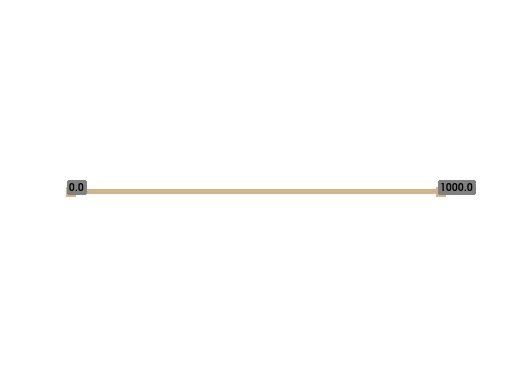

In [10]:
import pyvista as pv
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1280, 1024))
display.start()
p = pv.Plotter()
m = pv.read("m.vtk")
p.add_mesh(m, line_width=5)
pts = m.points
p.add_point_labels(pts, pts[:, 0].tolist(), point_size=10, font_size=10)
p.show(window_size=[512, 384], cpos="xy")
display.stop()

In [11]:
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION
BEGIN REGION 1
0/1 
END REGION 1
BEGIN REGION 2
0/0 
END REGION 2



### Definition of finite element methods and integration method
We will define three finite element methods. The first one, ```mfu``` is to approximate the displacement field. This is a vector field. This is defined in Python by

In [12]:
mfu = gf.MeshFem(mesh, 1)

elements_degree = 1
mfu.set_classical_fem(elements_degree)

where the 1 stands for the dimension of the vector field. The second line sets the finite element used.
```classical_fem``` means a continuous Lagrange element and remember that elements_degree has been set to 1 which means that we will use quadratic (isoparametric) elements.

The last thing to define is an integration method ```mim```. 
There is no default integration method in GetFEM so this is mandatory to define an integration method. 
Of course, the order of the integration method have to be chosen sufficient to make a convenient integration of the selected finite element method.
Here, the square of ```elements_degree``` is sufficient.

In [13]:
mim = gf.MeshIm(mesh, elements_degree * 2)

### Model definition
The model object in *GetFEM* gather the variables of the models (the unknowns), the data and what is called the model bricks.
The model bricks are some parts of the model (linear or nonlinear terms) applied on a single variable or linking several variables. 
They are used to make the assembly of the (tangent) linear system (see [The model object](https://getfem.readthedocs.io/en/latest/userdoc/model_object.html#ud-model-object) for more details).

followingThis is not strictly mandatory to use the model object since one may use directly the assembly procedures and build by it own the (tangent) linear system. 
The model object allows a rapid build of the model since most classical parts of a model are pre-programmed: standard boundary conditions, standard partial differential equations, use of multipliers to prescribe a constraint …
Moreover, some bricks are designed to extend the possibilities of the standard bricks (generic assembly bricks, explicit matrix brick …). Thus, it is recommended to use the framework of the model object.

There are two versions of the model: the real one and the complex one.
Complex models have to be reserved for special applications (some electromagnetism problems for instance) where it is advantageous to solve a complex linear system.

Let us declare a real model with the one variables corresponding to the three fields to be computed:

In [14]:
model = gf.Model("real")
model.add_fem_variable("u", mfu)

### Truss deformation problem

Let us now begin by truss deformation problem.
The equation on the deformation $u$ and boundary condition can be written as follows:
$$
\dfrac{d}{dx}\left\{EA\dfrac{du}{dx}\right\} =F
$$
is expressed also:
$$
\nabla ( D\nabla u) =F
$$
Where $D = EA$.

We use directly a GWFL term `add_linear_term(md mim, “E*A*Grad_u.Grad_Test_u)”`.
See Compute arbitrary terms - high-level generic assembly procedures - Generic Weak-Form Language (GWFL) for more details on GWFL.
$$
\int ^{L}_{0} EA\dfrac{du( x)}{dx}\dfrac{dv( x)}{dx} dx=\int ^{L}_{0} F v( x)dx
$$
$v$ it the test function of $u$.

In [15]:
model.add_linear_term?

Signature: model.add_linear_term(mim, expression, region=None, *args)
Docstring:
Synopsis: ind = Model.add_linear_term(self, MeshIm mim, string expression[, int region[, int is_symmetric[, int is_coercive]]])

Adds a matrix term given by the assembly string `expr` which will
be assembled in region `region` and with the integration method `mim`.
Only the matrix term will be taken into account, assuming that it is
linear.
The advantage of declaring a term linear instead of nonlinear is that
it will be assembled only once and no assembly is necessary for the
residual.
Take care that if the expression contains some variables and if the
expression is a potential or of first order (i.e. describe the weak
form, not the derivative of the weak form), the expression will be
derivated with respect to all variables.
You can specify if the term is symmetric, coercive or not.
If you are not sure, the better is to declare the term not symmetric
and not coercive. But some solvers (conjugate gradient f

In [16]:
model.add_initialized_data("D", [E * A])
model.add_linear_term(mim, "(D*Grad_u).Grad_Test_u")

0

Returned integer of `add_linear_term` show the index of the brick.

The equation of Model object will be:
$$
\begin{bmatrix}\dfrac{EA}{L} & -\dfrac{EA}{L}\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
0
\end{Bmatrix}
$$
You can assemble equtaion using `assembly` method.
After assembling, you can check stiffness tangent matrix and rhs of equation using `tangent_matrix` and `rhs` method.

In [17]:
model.assembly()
SM = model.tangent_matrix()
rhs = model.rhs()
print(SM)
print(rhs)

matrix(2, 2)
( (r0, 100) (r1, -100) )
( (r0, -100) (r1, 100) )

[0. 0.]


In [18]:
SM = gf.Spmat("empty", 2, 2)
SM.add(0, 0, E * A / L)
SM.add(0, 1, -E * A / L)
SM.add(1, 0, -E * A / L)
SM.add(1, 1, E * A / L)
print(SM)
# model.add_explicit_matrix("u", "u", SM)

matrix(2, 2)
( (r0, 100) (r1, -100) )
( (r0, -100) (r1, 100) )



The following program allows to take into account the whole elastic deformation equation.
Note the use of specific brick to prescribe the Dirichlet condition on the left boundary.
There is several option to prescribe a Dirichlet condition (see Dirichlet condition brick).

In [19]:
model.add_Dirichlet_condition_with_simplification?

Signature:
model.add_Dirichlet_condition_with_simplification(
    varname,
    region,
    dataname=None,
)
Docstring:
Adds a (simple) Dirichlet condition on the variable `varname` and
the mesh region `region`. The Dirichlet condition is prescribed by
a simple post-treatment of the final linear system (tangent system
for nonlinear problems) consisting of modifying the lines corresponding
to the degree of freedom of the variable on `region` (0 outside the
diagonal, 1 on the diagonal of the matrix and the expected value on
the right hand side).
The symmetry of the linear system is kept if all other bricks are
symmetric.
This brick is to be reserved for simple Dirichlet conditions (only dof
declared on the correspodning boundary are prescribed). The application
of this brick on reduced dof may be problematic. Intrinsic vectorial
finite element method are not supported. 
`dataname` is the optional right hand side of  the Dirichlet condition.
It could be constant (but in that case, it can o

In [20]:
model.add_Dirichlet_condition_with_simplification("u", LEFT)

1

The equation of Model object will be:
$$
\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
0
\end{Bmatrix}
$$

In [21]:
model.assembly()
SM = model.tangent_matrix()
rhs = model.rhs()
print(SM)
print(rhs)

matrix(2, 2)
( (r0, 1) )
( (r0, -100) (r1, 100) )

[0. 0.]


The following program allows to take into account the rhs of source force. Note the use of specific brick to prescribe the source term brick on the rhs of equation.

In [22]:
model.add_source_term_brick?

Signature: model.add_source_term_brick(mim, varname, dataexpr, region=None, *args)
Docstring:
Synopsis: ind = Model.add_source_term_brick(self, MeshIm mim, string varname, string dataexpr[, int region[, string directdataname]])

Add a source term to the model relatively to the variable `varname`.
The source term is
represented by `dataexpr` which could be any regular expression of the
high-level generic assembly language (except for the complex version
where it has to be a declared data of the model).
`region` is an optional mesh region
on which the term is added. An additional optional data `directdataname`
can be provided. The corresponding data vector will be directly added
to the right hand side without assembly. Note that when region is a
boundary, this brick allows to prescribe a nonzero Neumann boundary
condition. Return the brick index in the model.
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [23]:
model.add_initialized_data("F", [1.0])
ind = model.add_source_term_brick(mim, "u", "F", RIGHT)

The equation of Model object will be:
$$
\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
1
\end{Bmatrix}
$$

In [24]:
model.assembly()
SM = model.tangent_matrix()
rhs = model.rhs()
print(SM)
print(rhs)

matrix(2, 2)
( (r0, 1) )
( (r0, -100) (r1, 100) )

[0. 1.]


If you know the excplit rhs.
You can add it using `add_exclicit_rhs`:

In [25]:
model.add_explicit_rhs?

Signature: model.add_explicit_rhs(varname, L)
Docstring:
Add a brick representing an explicit right hand side to be added to
the right hand side of the tangent linear system relatively to the
variable `varname`. The given rhs should have the same size than the
dimension of `varname`. The rhs can be changed by the command
Model.set_private_rhs(). If `dataname` is specified instead of
`L`, the vector `L` is defined in the model as data with the given name.
Return the brick index in the model.
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [26]:
# model.add_explicit_rhs("u", [0.0, 1.0])

### Model solve
Once the model is correctly defined, we can simply solve it by:

In [27]:
model.solve()

(0, 1)

### Export of the solution

The finite element problem is now solved. 
We can get the value of displacement variable using `variable` method.

In [28]:
U = model.variable("u")
print(U)

[0.   0.01]


The model is simple enough to make sure the results are correct.

In [29]:
U = [0.0, L / E * A]
print(U)

[0.0, 0.01]


### Delete of brick

In the next section, we calculate a dynamic analysis, so we delete the static load brick. `delete_brick` method delete a variable or a data from the model.

In [30]:
model.delete_brick?

Signature: model.delete_brick(ind_brick)
Docstring: Delete a variable or a data from the model.
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [31]:
model.delete_brick(ind)

The equation of Model object will be:
$$
\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
0
\end{Bmatrix}
$$

In [32]:
model.assembly()
SM = model.tangent_matrix()
rhs = model.rhs()
print(SM)
print(rhs)

matrix(2, 2)
( (r0, 1) )
( (r0, -100) (r1, 100) )

[0. 0.]


### The model tools for the integration of transient problems

Although time integration scheme can be written directly using the model object by describing the problem to be solved at each iteration, the model object furnishes some basic tools to facilitate the writing of such schemes.
For example you can add Newmark scheme using `add_Newmark_scheme` method:

In [33]:
beta = 1.0 / 4.0
gamma = 1.0 / 2.0
model.add_Newmark_scheme("u", beta, gamma)

We use average constant acceleration ($\beta = \dfrac{1}{4}$, $\gamma = \dfrac{1}{2}$) which is unconditonally stable in linear model.

Some intermediate variables are added to the model to represent the time derivative (and the second order time derivative for second order problem).
For instance, if `u` is a variable, `Dot_u` will represent the first order time derivative of `u` and `Dot2_u` the second order one.
One can refer to these variables in the model to add a brick on it or to use it in GWFL, the generic weak form language. However, these are not considered to be independent variables, they will be linked to their corresponding original variable (in an affine way) by the time integration scheme.
Most of the schemes need also the time derivative at the previous time step and add the data `Previous_Dot_u` and possibly `Previous_Dot2_u` to the model.

Some data are added to the model to represent the state of the system at previous time steps.
For classical one-step schemes (for the moment, only one-step schemes are provided), only the previous time step is stored.
For instance if u is a variable (thus represented at step $n$), `Previous_u`, `Previous2_u`, `Previous3_u` will be the data representing the state of the variable at the previous time step (step $n-1$, $n-2$ and $n-3$).

### Mass matrix

The element consistent mass matrix is given by the following equation using the mass density and the test function of the element:
$$
M=\int_{0}^{L}\rho u\cdot vdx
$$
Mass brick adds a mass matrix on the tangent linear system with respect to a certain variable.
The function which adds this brick to a model is:

In [34]:
model.add_mass_brick?

Signature: model.add_mass_brick(mim, varname, dataexpr_rho=None, *args)
Docstring:
Synopsis: ind = Model.add_mass_brick(self, MeshIm mim, string varname[, string dataexpr_rho[, int region]])

Add mass term to the model relatively to the variable `varname`.
If specified, the data `dataexpr_rho` is the
density (1 if omitted). `region` is an optional mesh region on
which the term is added. If it is not specified, it
is added on the whole mesh. Return the brick index in the model.
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


In [35]:
# model.add_initialized_data("rho", rho)
# model.add_mass_brick(mim, "u", "rho")

Of cource we can also add the mass matrix using Generic Weak-Form Language (GWFL).

In [36]:
model.add_initialized_data("rho", [rho])
model.add_linear_term(mim, "rho*Dot2_u.Test_Dot2_u")

2

Excplict mass matrix is
$$
M=\dfrac{\rho AL}{6}\begin{bmatrix}2 & 1\\
1 & 2
\end{bmatrix}
$$
And the equation is
$$
\begin{bmatrix}1 & 0\\
\dfrac{\rho AL}{6} & \dfrac{\rho AL}{6}
\end{bmatrix}\begin{Bmatrix}\dfrac{\partial^{2}u_{0}}{\partial t^{2}}\\
\dfrac{\partial^{2}u_{1}}{\partial t^{2}}
\end{Bmatrix}+\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
0
\end{Bmatrix}
$$

Angular frequency without damping of this model is:
$$
\omega_{u}=\sqrt{\dfrac{k}{m}}
$$
$$
\omega_{d}=\dfrac{\sqrt{4mk-c^{2}}}{2m}
$$
with
$$
m = \dfrac{\rho AL}{3}
$$
$$
k = \dfrac{EA}{L}
$$

### Damping matrix
The damping matrix is given by the following equation using the viscous damping $\mu$ and the test function $v$.
$$
C=\int_{0}^{L}\mu u\cdot vdx
$$
However it is hard to compute the $mu$, we usually use Rayleigh damping.
$$
C=\alpha \cdot M + \beta \cdot K
$$

In [37]:
m = rho * A * L / 3.0
k = E * A / L
omega_u = np.sqrt(k / m)
omega_u

5805.8474978713775

In [38]:
h = 0.02
alpha = 2.0 * omega_u * h
beta = 2.0 * h / omega_u * h
c = alpha * m + beta * k
omega_d = np.sqrt(4.0 * m * k - c ** 2) / (2.0 * m)
omega_d

5804.639291409139

we can also add the matrix using Generic Weak-Form Language (GWFL) to `Dot_u`.

In [39]:
model.add_initialized_data("alpha", alpha)
model.add_initialized_data("beta", beta)
model.add_linear_term(
    mim, "alpha*rho*Dot_u.Test_Dot_u+beta*D*(Grad_Dot_u.Grad_Test_Dot_u)"
)

3

The equation is
$$
\begin{bmatrix}1 & 0\\
\dfrac{\rho AL}{6} & \dfrac{\rho AL}{3}
\end{bmatrix}\begin{Bmatrix}\dfrac{\partial^{2}u_{0}}{\partial t^{2}}\\
\dfrac{\partial^{2}u_{1}}{\partial t^{2}}
\end{Bmatrix}+\left(\alpha\begin{bmatrix}1 & 0\\
\dfrac{\rho AL}{6} & \dfrac{\rho AL}{3}
\end{bmatrix}+\beta\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\right)\begin{Bmatrix}\dfrac{\partial u_{0}}{\partial t}\\
\dfrac{\partial u_{1}}{\partial t}
\end{Bmatrix}+\begin{bmatrix}1 & 0\\
-\dfrac{EA}{L} & \dfrac{EA}{L}
\end{bmatrix}\begin{Bmatrix}u_{0}\\
u_{1}
\end{Bmatrix}=\begin{Bmatrix}0\\
0
\end{Bmatrix}
$$

### The implicit Newmark scheme for second order problems

The equation of Newmark theme is following ($n$ is the step of time):
$$
\left(K+\dfrac{\gamma}{\beta\Delta t}C+\dfrac{1}{\beta\Delta t^{2}}M\right)u_{n+1}=f_{n+1}+M\left(\left(\dfrac{1}{2\beta}-1\right)\dfrac{\partial^{2}u_{n}}{\partial t^{2}}+\dfrac{1}{\beta\Delta t}\dfrac{\partial u_{n}}{\partial t}+\dfrac{1}{\beta\Delta t^{2}}u_{n}\right)+C\left(\left(\dfrac{\gamma}{2\beta}-1\right)\Delta t_{n}\dfrac{\partial^{2}u_{n}}{\partial t^{2}}+\left(\dfrac{\gamma}{\beta}-1\right)\dfrac{\partial u_{n}}{\partial t}+\dfrac{\gamma}{\beta\Delta t}u_{n}\right)
$$
We can set the time step $dt$ using `set_time_step` method.

In [40]:
model.set_time_step?

Signature: model.set_time_step(dt)
Docstring:
Set the value of the time step to `dt`. This value can be change
from a step to another for all one-step schemes (i.e for the moment
to all proposed time integration schemes). 
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


It is generally recommended to use $1/20$ of the desired period for the time step.
So we use 1/20 of the natural period of the model.

In [41]:
T0 = 2.0*np.pi*np.sqrt(m/k)
dt = T0 / 20.0
model.set_time_step(dt)

We consider the case where the left side is fully constrained and the right side is subjected to a prescribed displacement of 1 mm.

In [42]:
U0 = np.array([0.0, 1.0]) # mm
V0 = np.array([0.0, 0.0]) # mm/sec
A0 = np.array([0.0, 0.0]) # mm/sec^2
model.set_variable("Previous_u", U0)
model.set_variable("Previous_Dot_u", U0)
model.set_variable("Previous_Dot2_u", A0)

Typically, the solve on the different time steps will take the following form:

In [43]:
T = np.array([])
U = np.array([])
for t in np.arange(0.0, 0.004, dt):
    model.solve()
    T = np.append(T, model.get_time())
    U = np.append(U, model.variable("u")[1])
    model.shift_variables_for_time_integration()

Note that the call of the method:

In [44]:
model.shift_variables_for_time_integration?

Signature: model.shift_variables_for_time_integration()
Docstring:
Function used to shift the variables of a model to the data
corresponding of ther value on the previous time step for time
integration schemes. For each variable for which a time integration
scheme has been declared, the scheme is called to perform the shift.
This function has to be called between two time steps. 
File:      /usr/lib/python3/dist-packages/getfem/getfem.py
Type:      method


is needed between two time step since it will copy the current value of the variables (`u` and `Dot_u` for instance) to the previous ones (`Previous_u` and `Previous_Dot_u`).

The comparison between the damping rate of the analytical solution and the FEM amplitude is plotted in the bottom figure. Both are in good agreement.
$$
u\left(t+nT\right)=\exp\left(-2\pi nh\dfrac{\omega_{u}}{\omega_{d}}\right)
$$

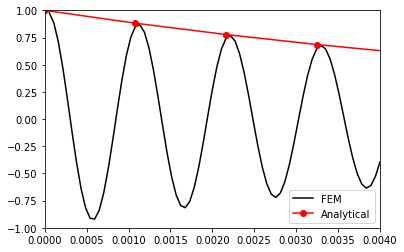

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(T, U, label="FEM", color="black")
n = np.arange(0, 5)
ax.plot(
    n * 2.0 * np.pi / omega_d,
    1.0 * np.exp(-2.0 * np.pi * n * h * omega_u / omega_d),
    color="red",
    marker="o",
    label="Analytical",
)
ax.set_xlim(0.000, 0.004)
ax.set_ylim(-1.000, 1.000)
ax.legend()

This is a small model example, but you can calculate the more complicated element in the same way.